In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import leafmap
import leafmap
import geemap
import ee
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [23]:
filepath = 'D:\Trainings\gee\Pabbi_RevisedLandtype-V3.geojson'
gdf=gpd.read_file(filepath)
gdf.head()

,Area_Acre,Crop_Type,FFID,Landuse_Ma,Mouza_Name,Parcel_ID,agri_count,built_count,NDVI,NDBI,...,NDWI,B2,B3,B4,B8,B11,pct_built,pct_agri,landuse_class,geometry
0,0.101785,None,1,Agriculture,Khushmaqam,668,1.721569,4.980392,0.226656,-0.016614,...,-0.261929,1080.794583,1314.424346,1412.001354,2250.015724,2147.930654,0.743125,0.256875,Partial-Builtup,"POLYGON ((71.74996 34.03193, 71.75027 34.03195..."
1,0.315557,None,3,Agriculture,Khushmaqam,632,5.627451,15.454902,0.254974,0.013744,...,-0.298905,905.980655,1133.265953,1248.493593,2115.168267,2148.237869,0.733073,0.266927,Partial-Builtup,"POLYGON ((71.74868 34.03205, 71.74869 34.03195..."
2,0.187644,None,4,Agriculture,Khushmaqam,669,4.796078,9.149020,0.248897,-0.003842,...,-0.284861,989.403836,1234.108843,1331.561342,2231.942662,2198.647527,0.656074,0.343926,Partial-Builtup,"POLYGON ((71.75021 34.03218, 71.75022 34.0321,..."
3,0.161568,None,5,Agriculture,Khushmaqam,693,6.192157,1.698039,0.410130,-0.109844,...,-0.431634,806.999988,1099.118312,1177.751882,2761.666157,2193.297278,0.215209,0.784791,Pure-Agriculture,"POLYGON ((71.75401 34.03224, 71.75403 34.03219..."
4,0.229336,None,6,Agriculture,Khushmaqam,667,2.674510,11.192157,0.197473,-0.011919,...,-0.233127,1160.127481,1376.297936,1480.144814,2196.267099,2126.134001,0.807127,0.192873,Pure-Builtup,"POLYGON ((71.74971 34.03192, 71.74996 34.03193..."


In [24]:
# Lets Convert the gdf of the original file to ee features utilizing earth engine power
ee.Initialize()
ee.Authenticate()
boundary = geemap.gdf_to_ee(gdf)

In [25]:
gdf.columns

Index(['Area_Acre', 'Crop_Type', 'FFID', 'Landuse_Ma', 'Mouza_Name',
       'Parcel_ID', 'agri_count', 'built_count', 'NDVI', 'NDBI', 'BUI', 'UI',
       'NDWI', 'B2', 'B3', 'B4', 'B8', 'B11', 'pct_built', 'pct_agri',
       'landuse_class', 'geometry'],
      dtype='object')

In [ ]:
# Dropping the unnecessary columns
gdf.drop(columns =['agri_count','built_count','pct_built','pct_agri'], inplace=True)
gdf.columns

KeyError: "['water_count'] not found in axis"

In [7]:
# Dropping the geometry column
gdf.drop(columns =['geometry'], inplace=True)
gdf.columns

Index(['Area_Acre', 'Crop_Type', 'FFID', 'Landuse_Ma', 'Mouza_Name',
       'Parcel_ID', 'NDVI', 'NDBI', 'BUI', 'UI', 'NDWI', 'landuse_class'],
      dtype='object')

In [8]:
# Checking for Null values.
print("Null values in the dataset: ", gdf.isnull().sum())
gdf.dropna(inplace=True)

Null values in the dataset:  Area_Acre           0
Crop_Type        5288
FFID                0
Landuse_Ma          0
Mouza_Name          0
Parcel_ID           0
NDVI                0
NDBI                0
BUI                 0
UI                  0
NDWI                0
landuse_class       0
dtype: int64


In [9]:
# Lets Encode teh target labels into numbers
labels_encoder = LabelEncoder()
gdf['landuse_class_encoded'] = labels_encoder.fit_transform(gdf['landuse_class'])

gdf['landuse_class_encoded'].value_counts()

landuse_class_encoded
3    325
1    102
2     30
4      9
0      5
Name: count, dtype: int64

In [11]:
# Lets seperte the featues and target

X = gdf[['NDVI','NDBI', 'BUI', 'UI', 'NDWI']]
y = gdf['landuse_class_encoded']

#save class labels for later decoding
class_names = labels_encoder.classes_

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
#Make the predictions
y_pred = rf_model.predict(X_test)


In [14]:
# Evaluate the Performance of the model

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
                      precision    recall  f1-score   support

              Mixed       0.00      0.00      0.00         1
Partial-Agriculture       0.76      0.84      0.80        31
    Partial-Builtup       0.75      0.67      0.71         9
   Pure-Agriculture       0.96      0.96      0.96        98
       Pure-Builtup       1.00      0.67      0.80         3

           accuracy                           0.90       142
          macro avg       0.69      0.63      0.65       142
       weighted avg       0.90      0.90      0.90       142

Confusion Matrix:
 [[ 0  1  0  0  0]
 [ 0 26  1  4  0]
 [ 0  3  6  0  0]
 [ 0  4  0 94  0]
 [ 0  0  1  0  2]]


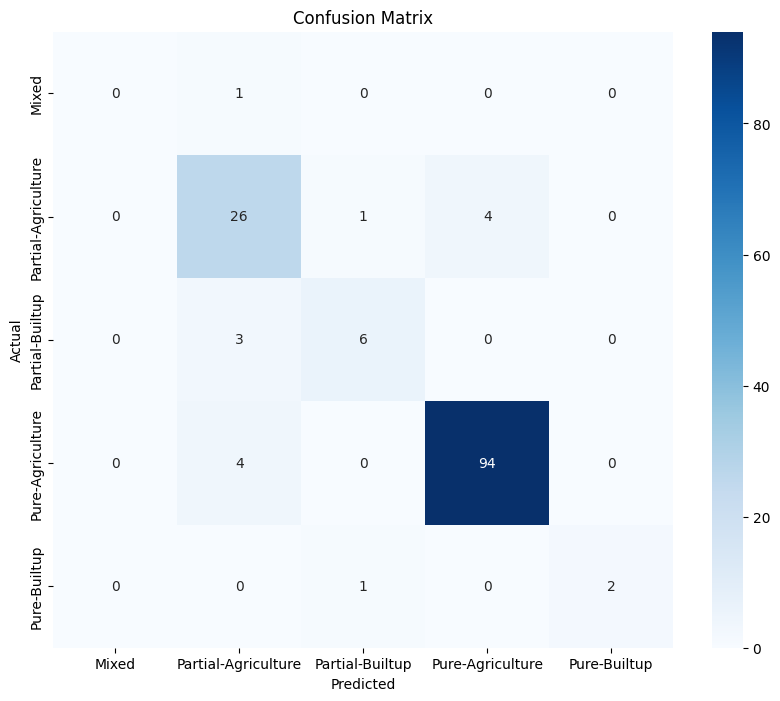

In [15]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# Lets save the model for future use
import joblib
joblib.dump(rf_model, 'Landcover_randomforest_model.pkl')   


['Landcover_randomforest_model.pkl']

# Now we will be using this model for prediction on the whole dataset

# Predict Per Pixel (raster-based classification) 
## Steps
1. Prepare dataset
2. Generate a feature Stack Raster
3. Train the Random Forest
4. Apply the Model to the Entire Raster
5. Visualize and Validate

In [ ]:
#1 Prepare the dataset 
# Make sure that the dataset has requisite bands information.

In [17]:
# Define a function to get imagery an apply filter
def get_collection (start_date,end_date):
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    filtered_collection = collection.filterDate(start_date, end_date).filterBounds(boundary.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    return filtered_collection

In [18]:
# defing ndvi , NDBI , BUI and UI indices
def get_indices(image):
    ndwi = image.normalizedDifference(['B8', 'B11']).rename('NDWI')
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
    bui = (
        image.select('B11').add(image.select('B4'))
        .subtract(image.select('B8'))
        .subtract(image.select('B2'))
        .divide(
            image.select('B11')
            .add(image.select('B4'))
            .add(image.select('B8'))
            .add(image.select('B2'))
        )
        .rename('BUI')
    )
    ui = image.expression(
        '(NDVI - NDBI) / (NDVI + NDBI)', {
            'NDBI': ndbi,
            'NDVI': ndvi
        }).rename('UI')
    
  
    return image.addBands(ndvi).addBands(ndbi).addBands(bui).addBands(ui).addBands(ndwi)


In [19]:
def get_composite(filtered_collection):

    # Selecting requisite bands
    selected_bands = ['B2', 'B3', 'B4', 'B8', 'B11']
    filtered_collection = filtered_collection.select(selected_bands)
    # Add the indices to the image collection   
    # Add all indices to each image in the colleciton
    indexed_collection = filtered_collection.map(get_indices)   

    #Reduce the entire colleciton to a mean composite image
    composite_img = indexed_collection.mean()

    #Clip to the boundary of pabbi
    composite_img = composite_img.clip(boundary.geometry())


    return composite_img


In [20]:
filtered_collection = get_collection('2022-01-01', '2024-12-31')
composite_img = get_composite(filtered_collection)

In [21]:
# Show the band names of the composite image
def show_band_names(composite_img):
    band_names = composite_img.bandNames().getInfo()
    print("Band names in the composite image:")
    for name in band_names:
        print(name)
show_band_names(composite_img)


Band names in the composite image:
B2
B3
B4
B8
B11
NDVI
NDBI
BUI
UI
NDWI


In [22]:


# 1. Define output filename
out_tif = 'sentinel2_features_indices.tif'

# 2. Export
geemap.ee_export_image(
    composite_img,
    filename=out_tif,
    scale=10,                                   # Sentinel-2 resolution
    region=boundary.geometry(),                 # your AOI
    file_per_band=False,                        # one multiband file
    crs='EPSG:4326'                             # or your preferred CRS
)

print(f"Exported multiband GeoTIFF: {out_tif}")


Generating URL ...
Please wait ...
Data downloaded to d:\Trainings\gee\sentinel2_features_indices.tif
Exported multiband GeoTIFF: sentinel2_features_indices.tif


import rasterio
import numpy as np
import joblib

# Load the trained Random Forest pipeline
pipeline = joblib.load('crop_rf_pipeline.pkl')
rf_model = pipeline['model']
feature_cols = pipeline['feature_cols']  # ['B2','B3','B4','B8','B11','NDVI','NDBI','BUI','UI','NDWI']

# Open the multiband GeoTIFF
with rasterio.open('sentinel2_features_indices.tif') as src:
    profile = src.profile.copy()
    data = src.read()  # shape: (bands, height, width)
    # Check that data.shape[0] matches len(feature_cols)
    assert data.shape[0] == len(feature_cols), "Band count mismatch with feature columns."

# Prepare feature array for prediction
# Stack and reshape: (bands, h, w) -> (h*w, bands)
bands, height, width = data.shape
X = np.transpose(data, (1, 2, 0)).reshape(-1, bands)  # shape: (height*width, bands)

# Predict land cover classes
y_pred = rf_model.predict(X)

# Reshape predictions back to 2D raster
classified = y_pred.reshape(height, width).astype(profile['dtype'])

# Update profile for single-band output
profile.update(
    count=1,
    dtype=classified.dtype,
    compress='lzw'
)

# Save classified land cover map
with rasterio.open('classified_map.tif', 'w', **profile) as dst:
    dst.write(classified, 1)

# Display a snippet of the classified map array
classified_snippet = classified[:5, :5]
classified_snippet
